In [1]:
import pandas as pd
import gzip
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm
import random
import numpy as np

In [2]:
LOCAL = 'Avenches'
# LOCAL = 'Lausanne'
FRACT_ACT = 1
FRACT_POP = 0.1
activity_types = ['work', 'education', 'leisure', 'shop']
TIME_INTERVAL = 5
HORIZON = round(24*60/TIME_INTERVAL) + 1

#### Generic functions :

In [3]:
def stratified_sample(df, column, fraction):
    """
    Perform stratified sampling on df based on column.
    :param df: Input dataframe
    :param column: Column name for stratification
    :param fraction: Fraction of rows to sample from each group
    :return: Sampled dataframe
    """
    return df.groupby(column).apply(lambda x: x.sample(frac=fraction)).reset_index(drop=True)

In [4]:
def round_to_horizon(t):
    """ Help to round a time to 5m intervals """
    # Convert datetime.time to datetime.datetime for calculations
    dt = datetime.combine(datetime.today(), t)
    
    # Find the number of seconds since midnight
    seconds_since_midnight = (dt - dt.replace(hour=0, minute=0, second=0, microsecond=0)).seconds

    # Round to the closest 5 minutes (300 seconds)
    rounded_seconds = round(seconds_since_midnight / (TIME_INTERVAL*60)) * TIME_INTERVAL*60
    rounded_dt = dt.replace(hour=0, minute=0, second=0) + timedelta(seconds=rounded_seconds)

    return rounded_dt.time()

def time_to_horizon_interval(t):
    """ Return time horizon corresponding to a timestamp """
    rounded_time = round_to_horizon(t)
    
    # Convert datetime.time to datetime.datetime for calculations
    dt = datetime.combine(datetime.today(), rounded_time)
    
    # Get total minutes since midnight
    minutes_since_midnight = (dt - dt.replace(hour=0, minute=0, second=0)).seconds // 60

    # Convert total minutes to horizon intervals (5 minute intervals)
    horizon_interval = minutes_since_midnight // TIME_INTERVAL

    return horizon_interval

#### Preprocessing

Read the data and filter the irrelevants columns

In [5]:
activity_file = 'Data/Original/vaud_activities.csv.gz'
population_file = 'Data/Original/vaud_population.csv.gz'
trip_file = 'Data/Original/vaud_trips.csv.gz'

def read_gzipped_csv(file_path):
    with gzip.open(file_path, 'rt') as file:
        df = pd.read_csv(file)
    return df

activity_vaud = read_gzipped_csv(activity_file)[['id', 'type', 'facility', 'x', 'y', 'start_time', 'end_time']]
population_vaud = read_gzipped_csv(population_file)[['id', 'local', 'age', 'employed', 'home_x', 'home_y']]

Filter the population by the city

In [6]:
population_local = population_vaud[population_vaud['local'] == LOCAL] 
# print(len(population_local))
# population_local.head(1)

Use the filtered population to extract activities of the same city. Also count the activities by type in this city. 

In [7]:
population_local_ids = population_local['id'].unique()
activity_local = activity_vaud[activity_vaud['id'].isin(population_local_ids)]
activity_local_filt_nowork = activity_local[~activity_local['type'].isin(['other', 'pt interaction', 'home', 'work'])] 
# count_act_by_types = activity_local_filt.groupby('type')['facility'].nunique().reset_index()
# print(f"Here's the count of facilities by types in {LOCAL} : {count_act_by_types}")
# print(len(activity_local_filt))
# activity_local_filt.head(2)

Sample the activities of this city by keeping the proportion between each type (stratified sampling)

In [8]:
# peut etre associer un seed pour avoir toujours le meme resultat ? 
# Attention : stratified sampling != proportional sampling 
activity_local_filt_sampled = stratified_sample(activity_local_filt_nowork, column='type', fraction=FRACT_ACT) # 0.001 to compare exact / heuristic
# activity_local_filt_sampled.drop(columns=['start_time', 'end_time'], inplace=True)
# print(len(activity_local_filt))
# print(len(activity_local_filt_sampled))
# count_act_by_types_sampled = activity_local_filt_sampled.groupby('type')['facility'].nunique().reset_index()
# print(f"Here's the count of facilities by types in the sample : {count_act_by_types_sampled}")
# activity_local_filt_sampled.head()

Create new columns for each activity with their caracterics (anticipate initialization)

In [9]:
# 0 = 00:00 // 288 = 24:00 (total len = 289)
# Code to fix the following values for each activity type : 
    # t1 = earliest time to start
    # t2 = latest time to start
    # t3 = max duration
    # min duration
    # des duration

for i, row in activity_local_filt_sampled.iterrows():
    type_ = row['type']
    match type_: 
        case 'education':
            activity_local_filt_sampled.at[i, 'group'] = 1
            activity_local_filt_sampled.at[i, 'earliest_start'] = 7*60/TIME_INTERVAL # 6h
            activity_local_filt_sampled.at[i, 'latest_start'] = 23*60/TIME_INTERVAL # 23h
            activity_local_filt_sampled.at[i, 'max_duration'] = 10*60/TIME_INTERVAL # 10h
            activity_local_filt_sampled.at[i, 'min_duration'] = 10/TIME_INTERVAL # 10m
        case 'leisure':
            activity_local_filt_sampled.at[i, 'group'] = 3
            activity_local_filt_sampled.at[i, 'earliest_start'] = 7*60/TIME_INTERVAL # 6h
            activity_local_filt_sampled.at[i, 'latest_start'] = 23*60/TIME_INTERVAL # 23h
            activity_local_filt_sampled.at[i, 'max_duration'] = 10*60/TIME_INTERVAL # 10h
            activity_local_filt_sampled.at[i, 'min_duration'] = 10/TIME_INTERVAL # 10m
        case 'shop':
            activity_local_filt_sampled.at[i, 'group'] = 4
            activity_local_filt_sampled.at[i, 'earliest_start'] = 7*60/TIME_INTERVAL # 7h
            activity_local_filt_sampled.at[i, 'latest_start'] = 23*60/TIME_INTERVAL # 23h
            activity_local_filt_sampled.at[i, 'max_duration'] = 10*60/TIME_INTERVAL # 10h
            activity_local_filt_sampled.at[i, 'min_duration'] = 10/TIME_INTERVAL # 10m
            
int_columns = ['earliest_start', 'latest_start', 'max_duration', 'min_duration', 'x', 'y', 'group']
activity_local_filt_sampled[int_columns] = activity_local_filt_sampled[int_columns].astype(int) 
# Proof that we have a activity id : 
# print(len(activity_local_filt_sampled))
# print(activity_local_filt_sampled.index.nunique())

Sample the individuals among the city inhabitants and converts home coordinates in `int`

In [10]:
population_local_sample = population_local.sample(frac = FRACT_POP)
# print(len(population_local))
# print(len(population_local_sample))
# population_local_sample.head(1)
# activity_local_filt_sampled.head()

Filter invalid times (hours < 24) & Convert time object in terms of horizons  

In [11]:
pd.set_option('mode.chained_assignment', None)

activity_local_filt = activity_local[~activity_local['type'].isin(['other', 'pt interaction', 'home'])] 

# Assuming 'start_time' and 'end_time' are in a format recognized by pandas (like 'HH:MM:SS')
activity_local_filt['start_time'] = pd.to_timedelta(activity_local_filt['start_time'].astype(str))
activity_local_filt['end_time'] = pd.to_timedelta(activity_local_filt['end_time'].astype(str))

# Filter out any NaT values or times that are not within the correct range
# For example, checking that 'start_time' and 'end_time' are less than 24 hours
activity_local_filt = activity_local_filt[
    (activity_local_filt['start_time'] < pd.Timedelta('1 days')) &
    (activity_local_filt['end_time'] < pd.Timedelta('1 days'))
]

# Convert 'start_time' and 'end_time' to 'datetime.time' if they are within a single day.
activity_local_filt['start_time'] = activity_local_filt['start_time'].apply(
    lambda x: (datetime.min + x).time() if isinstance(x, pd.Timedelta) and x < pd.Timedelta(days=1) else x
)
activity_local_filt['end_time'] = activity_local_filt['end_time'].apply(
    lambda x: (datetime.min + x).time() if isinstance(x, pd.Timedelta) and x < pd.Timedelta(days=1) else x
)

# print(activity_local_filt.head())

activity_local_filt['start_time_interval'] = activity_local_filt['start_time'].apply(time_to_horizon_interval)
activity_local_filt['end_time_interval'] = activity_local_filt['end_time'].apply(time_to_horizon_interval)
activity_local_filt['duration_interval'] = activity_local_filt['end_time_interval'] - activity_local_filt['start_time_interval']

# print(len(activity_local_filt))
# activity_local_filt.head(30)

For each individual, and for each activity type, add starting time and duration preferences

In [12]:
id_range1 = population_local[(population_local['age'] >= 0) & (population_local['age'] <= 18)]
id_range2_emp = population_local[(population_local['age'] >= 19) & (population_local['age'] <= 35) & (population_local['employed'] == True)]
id_range3_emp = population_local[(population_local['age'] >= 36) & (population_local['age'] <= 65) & (population_local['employed'] == True)]
id_range4_emp = population_local[(population_local['age'] >= 66) & (population_local['age'] <= 100) & (population_local['employed'] == True)]
id_range2_unemp = population_local[(population_local['age'] >= 21) & (population_local['age'] <= 40) & (population_local['employed'] == False)]
id_range3_unemp = population_local[(population_local['age'] >= 41) & (population_local['age'] <= 65) & (population_local['employed'] == False)]
id_range4_unemp = population_local[(population_local['age'] >= 66) & (population_local['age'] <= 100) & (population_local['employed'] == False)]

In [13]:
def calculate_distributions(sub_population, activity_local_filt):
    '''Fonction pour calculer la distribution des intervalles de temps de début et de durée
    Returns a dictionary distributions['start_time_interval'] = count // distributions['duration_interval'] = count'''
    distributions = {}
    sub_population_ids = sub_population['id'].unique()
    filtered_activities = activity_local_filt[activity_local_filt['id'].isin(sub_population_ids)]

    for activity_type in filtered_activities['type'].unique():
        activity_data = filtered_activities[filtered_activities['type'] == activity_type]
        start_dist = activity_data['start_time_interval'].value_counts(normalize=True)
        duration_dist = activity_data['duration_interval'].value_counts(normalize=True)
        distributions[activity_type] = {'start': start_dist, 'duration': duration_dist}
    
    return distributions

def get_subpopulation_id(person):
    age, employed = person['age'], person['employed']
    if age <= 18:
        return 'range1'
    elif age <= 35:
        return 'range2_emp' if employed else 'range2_unemp'
    elif age <= 65:
        return 'range3_emp' if employed else 'range3_unemp'
    else:
        return 'range4_emp' if employed else 'range4_unemp'

# Calculer les distributions pour chaque sous-population
distributions = {
    'range1': calculate_distributions(id_range1, activity_local_filt),
    'range2_emp': calculate_distributions(id_range2_emp, activity_local_filt),
    'range3_emp': calculate_distributions(id_range3_emp, activity_local_filt),
    'range4_emp': calculate_distributions(id_range4_emp, activity_local_filt),
    'range2_unemp': calculate_distributions(id_range2_unemp, activity_local_filt),
    'range3_unemp': calculate_distributions(id_range3_unemp, activity_local_filt),
    'range4_unemp': calculate_distributions(id_range4_unemp, activity_local_filt),
}
# print(distributions['range2_emp'])

In [14]:
def get_preferences(id, type, df):
    ''' (deprecated) Returns the duration and starting preference for an individual and an activity 
    Returns default value for each activity that the individual didn't do
    NOW : just used to determine participation'''
    row = df.loc[(df['id'] == id) & (df['type'] == type)]
    
    if row.empty:
        # return default_durations[type], default_starting[type], 0
        return 0
    else:
        # Assuming there's only one matching row, so taking the first one
        # duration = row['duration_interval'].iloc[0]
        # starting_time = row['start_time_interval'].iloc[0]
        # return duration, starting_time, 1
        return 1

In [15]:
rows_of_interessed = activity_local_filt[activity_local_filt['id'].isin(population_local_sample['id'])]

# Initialisation des colonnes pour les durées et heures de début d'activité
for activity_type in activity_types:
    population_local_sample[f'{activity_type}_start'] = 0  
    population_local_sample[f'{activity_type}_dur'] = 0   
    population_local_sample[f'{activity_type}_part'] = 0  

# Pour chaque individu et activity type, choisir aléatoirement un intervalle de temps de début et de durée
for index, person in population_local_sample.iterrows():
    subpop_id = get_subpopulation_id(person)
    for activity_type, dist in distributions[subpop_id].items():
        if dist['start'].empty or dist['duration'].empty:
            chosen_start = 0
            chosen_duration = 0
        else:
            chosen_start = np.random.choice(dist['start'].index, p=dist['start'].values)
            chosen_duration = np.random.choice(dist['duration'].index, p=dist['duration'].values)
        
        # Les enfants ne travaillent pas
        if (subpop_id == 'range1' and activity_type == 'work'):
            chosen_start = 0
            chosen_duration = 0
        
        population_local_sample.at[index, f'{activity_type}_start'] = chosen_start
        population_local_sample.at[index, f'{activity_type}_dur'] = chosen_duration
        population_local_sample.at[index, f'{activity_type}_part'] = get_preferences(person['id'], activity_type, rows_of_interessed)


Pick a random work facility for each individual according to the workplace distribution

In [16]:
df_work_facilities = activity_local[activity_local['type'] == 'work']
print(f"There are {df_work_facilities['facility'].nunique()} work facilities in {LOCAL}")
work_facilities_count = df_work_facilities.groupby('facility')['id'].count()

# Créer un DataFrame résumé avec les coordonnées moyennes pour chaque établissement
facility_coords = df_work_facilities.groupby('facility')[['x', 'y']].mean()

# Créer le dictionnaire pour les coordonnées x et y des établissements
facility_coords_dict = facility_coords.to_dict('index')

# Choisir un établissement pour chaque individu dans l'échantillon
N = len(population_local_sample)
facilities = work_facilities_count.index.tolist()
workers = work_facilities_count.tolist()
chosen_facilities = random.choices(facilities, weights=workers, k=N)

# Assigner les coordonnées x, y et l'ID de l'établissement choisi
population_local_sample['work_id'] = chosen_facilities
population_local_sample['work_x'] = [facility_coords_dict[facility]['x'] for facility in chosen_facilities]
population_local_sample['work_y'] = [facility_coords_dict[facility]['y'] for facility in chosen_facilities]
# population_local_sample.head()

There are 791 work facilities in Avenches


Write the final preprocessed dataframes into .csv files

In [17]:
int_columns_2 = ['home_x', 'home_y', 'work_x', 'work_y', 'work_id', 'work_start', 'shop_start', 'leisure_start', 'education_start',
                 'work_dur', 'shop_dur', 'leisure_dur', 'education_dur'] 
population_local_sample[int_columns_2] = population_local_sample[int_columns_2].astype(int) 

In [18]:
activity_local_filt_sampled.drop(['start_time', 'end_time'], axis=1).to_csv(f'Data/PreProcessed/activity_5m.csv', index=False)
population_local_sample.to_csv(f'Data/PreProcessed/population_5m.csv', index=False) 

Create 2 other files for 10m preferences

In [19]:
col = ['earliest_start','latest_start','max_duration','min_duration']
for c in col:
    activity_local_filt_sampled[c] = round(activity_local_filt_sampled[c]/2)

activity_local_filt_sampled[col] = activity_local_filt_sampled[col].astype(int) 
activity_local_filt_sampled.drop(['start_time', 'end_time'], axis=1).to_csv(f'Data/PreProcessed/activity_10m.csv', index=False)

for activity_type in activity_types:
    population_local_sample[f'{activity_type}_start'] = round(population_local_sample[f'{activity_type}_start']/2)
    population_local_sample[f'{activity_type}_dur'] = round(population_local_sample[f'{activity_type}_dur']/2)

int_columns_2 = ['home_x', 'home_y', 'work_x', 'work_y', 'work_id', 'work_start', 'shop_start', 'leisure_start', 'education_start',
                 'work_dur', 'shop_dur', 'leisure_dur', 'education_dur'] 
population_local_sample[int_columns_2] = population_local_sample[int_columns_2].astype(int) 
population_local_sample.to_csv(f'Data/PreProcessed/population_10m.csv', index=False) 

# Exploration

In [20]:
# Drop rows where any of the required columns have NaNs
population_local_sample.dropna(subset=['home_x', 'home_y', 'work_x', 'work_y'], inplace=True)

# Now apply the distance calculation
population_local_sample['distance_H2W'] = np.sqrt(
    (population_local_sample['home_x'] - population_local_sample['work_x'])**2 +
    (population_local_sample['home_y'] - population_local_sample['work_y'])**2
)
population_local_sample['distance_H2W'].mean()

c:\Users\helli\anaconda3\envs\schedule\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


10724.742271670759

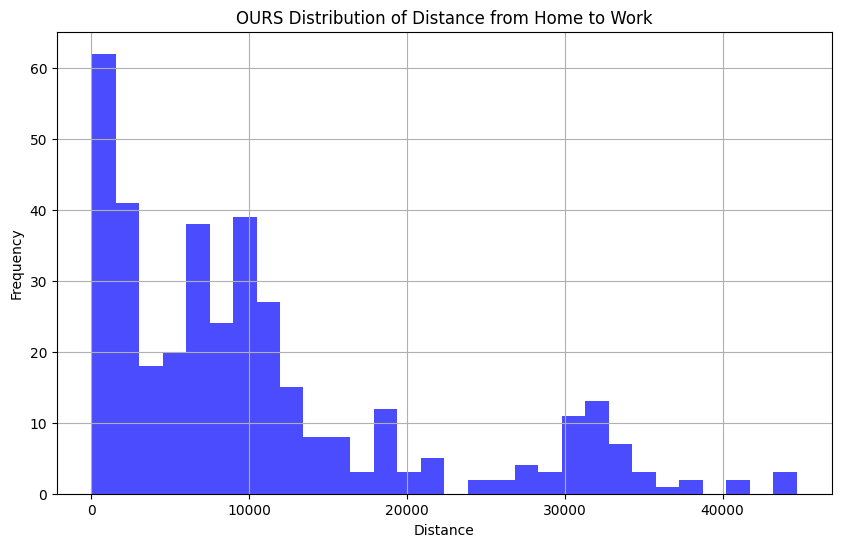

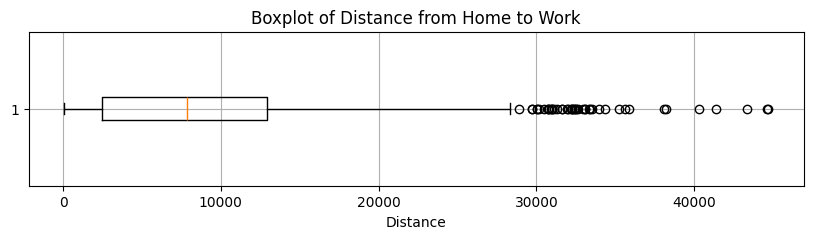

In [21]:
import matplotlib.pyplot as plt
# Plot the distribution of distance
plt.figure(figsize=(10, 6))
plt.hist(population_local_sample['distance_H2W'], bins=30, alpha=0.7, color='blue')
plt.title('OURS Distribution of Distance from Home to Work')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot the boxplot of the distance
plt.figure(figsize=(10, 2))
plt.boxplot(population_local_sample['distance_H2W'].dropna(), vert=False)  # Drop NA values for boxplot
plt.title('Boxplot of Distance from Home to Work')
plt.xlabel('Distance')
plt.grid(True)
plt.show()

In [22]:
merged = df_work_facilities.merge(population_local, how='left', on='id')
# merged.head()

In [23]:
# Drop rows where any of the required columns have NaNs
merged.dropna(subset=['home_x', 'home_y', 'x', 'y'], inplace=True)

# Now apply the distance calculation
merged['distance_H2W'] = np.sqrt(
    (merged['home_x'] - merged['x'])**2 +
    (merged['home_y'] - merged['y'])**2
)
merged['distance_H2W'].mean()

17162.495108580977

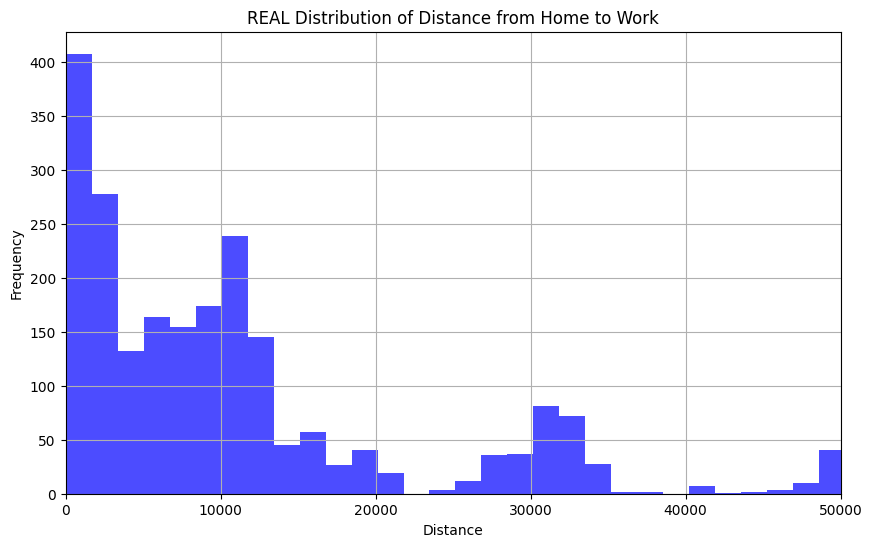

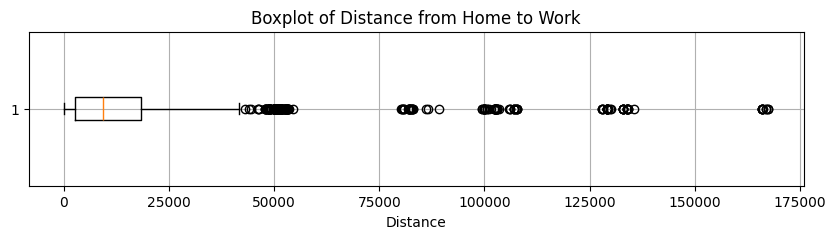

In [24]:
# Plot the distribution of distance
plt.figure(figsize=(10, 6))
plt.hist(merged['distance_H2W'], bins=100, alpha=0.7, color='blue')
plt.title('REAL Distribution of Distance from Home to Work')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.xlim((0, 50000))
plt.grid(True)
plt.show()

# Plot the boxplot of the distance
plt.figure(figsize=(10, 2))
plt.boxplot(merged['distance_H2W'].dropna(), vert=False)  # Drop NA values for boxplot
plt.title('Boxplot of Distance from Home to Work')
plt.xlabel('Distance')
plt.grid(True)
plt.show()